In [395]:
%matplotlib inline
import matplotlib.pyplot as plt
from itertools import cycle, islice, chain, repeat
from os import listdir, path
from os.path import isfile, join
from PIL import Image
import numpy as np
import math
from datetime import datetime
from pathos.multiprocessing import cpu_count, ProcessingPool

In [396]:
def with_white_bg(image):
    white_bg = Image.new(mode='RGBA', size=image.size, color='white')
    white_bg.paste(image, mask=image)
    return white_bg


def red(image):
    arr = np.asarray(image).copy()
    rgb = arr[:,:,1:3]
    arr[:,:,1:3][np.where(rgb == 255)] = 0
    red_rank = Image.fromarray(arr)
    return with_white_bg(red_rank)


def black(image):
    arr = np.asarray(image).copy()
    rgb = arr[:,:,0:3]
    arr[:,:,0:3][np.where(rgb == 255)] = 0
    black_rank = Image.fromarray(arr)
    return with_white_bg(black_rank)


def load_rank_images(rank_images_dir):
    for name in listdir(rank_images_dir):
        full_path = join(rank_images_dir, name)
        if not isfile(full_path):
            continue

        rank = path.splitext(path.basename(full_path))[0]
        image = Image.open(full_path)
        red_image = red(image)
        black_image = black(image)

        yield (red_image, rank)
        yield (black_image, rank)


def warp(img, angle, center, new_center, scale):
    angle = -angle/180.0*math.pi
    nx,ny = x,y = center
    sx=sy=1.0
    (nx,ny) = new_center
    (sx,sy) = scale
    cosine = math.cos(angle)
    sine = math.sin(angle)
    a = cosine/sx
    b = sine/sx
    c = x-nx*a-ny*b
    d = -sine/sy
    e = cosine/sy
    f = y-nx*d-ny*e
    
    img = img.transform(img.size, Image.AFFINE, (a,b,c,d,e,f))
    bg = Image.new('RGB', img.size, 'white')
    
    return Image.composite(img, bg, img)


def warp_rnd(image, level=1):
    r = lambda v: v * (.5 - np.random.rand()) * 2 * level
    width, height = image.size
    
    angle = r(90)
    center = width/2 + r(width/4), height/2 + r(height/4)
    new_center = width/2 + r(width/4), height/2 + r(height/4)
    scale = 1 + r(.5), 1 + r(.5)
    
    return warp(image, angle, center, new_center, scale)


def gen_rank_samples(rank_images_dir, count, rnd_level=.2):
    samples = list(load_rank_images('res/cards/rank'))
    samples = [(warp_rnd(image, rnd_level), label) for (image, label) in islice(cycle(samples), 0, count)]
    images, labels = zip(*samples)
    return images, labels

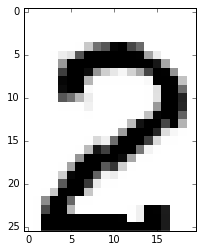

In [397]:
rank_images, rank_labels = gen_rank_samples('res/cards/rank', 50)
img = rank_images[47]
plt.imshow(img, interpolation='none')

In [380]:
rank_labels

('K',
 'K',
 'J',
 'J',
 '8',
 '8',
 '9',
 '9',
 '4',
 '4',
 'T',
 'T',
 '5',
 '5',
 '7',
 '7',
 'A',
 'A',
 '6',
 '6',
 '2',
 '2',
 '3',
 '3',
 'Q',
 'Q',
 'K',
 'K',
 'J',
 'J',
 '8',
 '8',
 '9',
 '9',
 '4',
 '4',
 'T',
 'T',
 '5',
 '5',
 '7',
 '7',
 'A',
 'A',
 '6',
 '6',
 '2',
 '2',
 '3',
 '3')